In [43]:
%matplotlib inline

from ipyleaflet import Map, ImageOverlay, Polyline
import matplotlib
import matplotlib.cm
from matplotlib import pyplot
import numpy as np
import numpy.lib.recfunctions
import scipy
import scipy.interpolate
import pandas
import platypus.io.logs
import os
import uuid
import glob

In [44]:
# Import the data from the specified logfile
log_path = "/home/jason/Documents/Platypus/phone logs/netherlands/Nov2017Shawn/netherlands day two/"
log_filenames = [
                log_path + "platypus_20171119_081603.txt",
                log_path + "platypus_20171119_093819.txt",
                #####log_path + "platypus_20171119_032804.txt"
                log_path + "platypus_20171119_105709.txt",
                #####log_path + "platypus_20171119_035612.txt",
                #####log_path + "platypus_20171119_031056.txt",
                log_path + "platypus_20171119_102933.txt",
                log_path + "platypus_20171119_112232.txt"
                ]
csv_output_filename = "Nov2017ShawnNetherlands"
log_ext = ".txt"

#data = platypus.io.logs.load(log_path + log_filename + log_ext)
data = platypus.io.logs.merge_files(log_filenames)

if "ES2" in data:
    print "ES2 sensor is present. Trimming all data within EC = 0 time windows\n"
    # find all time windows where EC is exactly 0
    ES2_data = data["ES2"]
    values = ES2_data["ec"].values
    #ec_eq_zero_indices = np.where(values == 0)[0]
    ec_eq_zero_indices = np.where(values < 200)[0]
    windows = list()
    windows.append([ec_eq_zero_indices[0]])
    left = ec_eq_zero_indices[0]
    for ii in range(1, ec_eq_zero_indices.shape[0]):
        i = ec_eq_zero_indices[ii]
        if i - left > 5:
            # there has been a jump in index, a new time window has started
            windows[-1].append(left)
            windows.append([i])
        left = i
    windows[-1].append(ec_eq_zero_indices[-1])
    # print ec_eq_zero_indices
    # print windows
    for window in windows:
        time_window = [ES2_data["ec"].index.values[window[0]], ES2_data["ec"].index.values[window[1]]]
        for k in data:
            data[k] = data[k].loc[np.logical_or(data[k].index < time_window[0], data[k].index > time_window[1])]
else:
    print "No ES2 sensor present. No trimming will be performed."
    
"""
if "ATLAS_PH" in data:
    print "pH sensor is present. Trimming all data within pH < 6 time windows\n"
    # find all time windows where pH is less than 6
    pH_data = data["ATLAS_PH"]
    values = pH_data["ph"].values
    pH_lt_6_indices = np.where(values < 6)[0]
    windows = list()
    windows.append([pH_lt_6_indices[0]])
    left = pH_lt_6_indices[0]
    for ii in range(1, pH_lt_6_indices.shape[0]):
        i = pH_lt_6_indices[ii]
        if i - left > 5:
            windows[-1].append(left)
            windows.append([i])
        left = i
    windows[-1].append(pH_lt_6_indices[-1])
    for window in windows:
        time_window = [pH_data["ph"].index.values[window[0]], pH_data["ph"].index.values[window[1]]]
        for k in data:
            data[k] = data[k].loc[np.logical_or(data[k].index < time_window[0], data[k].index > time_window[1])]
"""

# Define useful access variables.
pose = data['pose']
position = pose[['latitude', 'longitude']]

# Print the available sensors and channels for this logfile.
print "Available sensors/channels:"
for s in data.keys():
    if s == 'pose' or s == 'BATTERY':
        continue
    for c in data[s].dtypes.keys():
        print "  {:s}, {:s}".format(s, str(c))

set([u'ATLAS_PH', u'BATTERY', 'pose', u'ES2'])
ES2 sensor is present. Trimming all data within EC = 0 time windows

Available sensors/channels:
  ATLAS_PH, ph
  ES2, ec
  ES2, temperature


In [45]:
# Select the sensor and the name of the channel for that sensor.
sensor_name = 'ES2'
sensor_channel = 'ec'
sensor_units = 'Electrical Conductivity (uS/cm)'
#sensor_units = 'Temperature (C)'
#sensor_units = 'Dissolved Oxygen (mg/L)'
#sensor_units = "pH"

In [46]:
# Extract the pose timing and the sensor data of interest.
pose_times = pose.index.values.astype(np.float64)

if sensor_name in data:
    sensor = data[sensor_name]
    sensor_times = sensor.index.values.astype(np.float64)

    # Linearly interpolate the position of the sensor at every sample.
    sensor_pose_interpolator = scipy.interpolate.interp1d(pose_times, position,
                                                          axis=0, bounds_error=False)

    # Add the position information back to the sensor data.
    sensor = sensor.join(pandas.DataFrame(sensor_pose_interpolator(sensor_times), sensor.index,
                                          columns=('latitude', 'longitude')))
    
    # print sensor data to csv file
    sensor.to_csv(log_path + csv_output_filename + "__" + sensor_name + ".csv")

    # Remove columns that have NaN values (no pose information).
    sensor_valid = np.all(np.isfinite(sensor), axis=1)
    sensor = sensor[sensor_valid]

In [47]:
# Create a trail of the vehicle's path on the map.
pl = Polyline(locations=position.as_matrix().tolist())
pl.fill_opacity = 0.0
pl.weight = 2

In [48]:
# Add a data overlay for the map
data_padding = [0.0001, 0.0001]   # degrees lat/lon
data_resolution = [0.00001, 0.00001] # degrees lat/lon
data_interpolation_radius = 0.00005 # degrees lat/lon
data_bounds = [(position.min() - data_padding).tolist(),
               (position.max() + data_padding).tolist()]

# Create a rectangular grid of overlay points.
data_xv, data_yv = np.meshgrid(
    np.arange(data_bounds[1][0], data_bounds[0][0], -data_resolution[0]),
    np.arange(data_bounds[0][1], data_bounds[1][1], data_resolution[1])
)
data_shape = data_xv.shape
data_xy = np.vstack([data_xv.ravel(), data_yv.ravel()]).T

if sensor_name in data:
    # Create a radial-basis interpolator over the sensor dataset
    # Then, query it at each point of the rectangular grid.
    #from sklearn.neighbors import RadiusNeighborsClassifier
    #data_estimator = RadiusNeighborsClassifier(radius=data_interpolation_radius, outlier_label=np.nan)
    from sklearn.neighbors import RadiusNeighborsRegressor
    data_estimator = RadiusNeighborsRegressor(radius=data_interpolation_radius)

    data_estimator.fit(sensor[['latitude','longitude']], sensor[sensor_channel].astype(np.float))
    data_zv = data_estimator.predict(data_xy)
    data_zv = data_zv.reshape(data_shape).T

    # Normalize data from [0, 1)
    data_max = data_zv[np.isfinite(data_zv)].max()
    data_min = data_zv[np.isfinite(data_zv)].min()
    print "Data min = {:f}   Data max = {:f}".format(data_min, data_max)
    NORMALIZER = data_max # 800
    data_zv = (data_zv - data_min) / (NORMALIZER - data_min)

    # Update a color map only at the points that have valid values.
    data_rgb = np.zeros((data_shape[0], data_shape[1], 4), dtype=np.uint8)
    data_rgb = matplotlib.cm.jet(data_zv)*255.0
    data_rgb[:,:,3] = 255 * np.isfinite(data_zv)

    # Remove any old image files.
    old_png_files = glob.glob('./*.png')
    for old_png_file in old_png_files:
        os.remove(old_png_file)

    png_filename = './platypus_data_{:s}.png'.format(uuid.uuid4())
    scipy.misc.imsave(png_filename, data_rgb)

    # Create image overlay that references generated image.
    io = ImageOverlay(url=png_filename, bounds=data_bounds)

Data min = 241.000000   Data max = 1850.500000


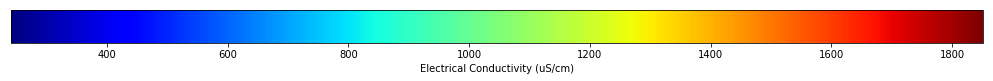

In [49]:

# Create a map centered on this data log.
center = [pose['latitude'].median(), pose['longitude'].median()]
# print center
zoom = 17
m = Map(center=center, zoom=zoom, height='1000px')
if sensor_name in data:
    m += io # Add image overlay
if sensor_name not in data:
    m += pl # Add vehicle trail, but only if there isn't heatmap data to look at

# Make a figure and axes with dimensions as desired.
fig = pyplot.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

if sensor_name in data:
    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.        
    cmap = matplotlib.cm.jet
    norm = matplotlib.colors.Normalize(vmin=data_min, vmax=NORMALIZER)
    cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                           norm=norm,
                                           orientation='horizontal')
    cb1.set_label(sensor_units)

pyplot.show()
m